# **Imports and Downloads**

In [2]:
# Standard Libraries
import csv
import re
from collections import Counter
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# Word Embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

# Utilities
from tqdm import tqdm

# Suppress Warnings
warnings.filterwarnings('ignore')

In [4]:
# Download WordNet data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

# Load pre-trained Word2Vec model
word2vec_model = api.load("word2vec-google-news-300")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Load Data**

In [5]:
filename = "final_hateXplain.csv"

final_hateXplain_fields = []
final_hateXplain_rows = []

with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    final_hateXplain_fields = next(csvreader)

    for final_hateXplain_row in csvreader:
        final_hateXplain_rows.append(final_hateXplain_row)

    print("Total no. of rows: %d" % (csvreader.line_num))

final_hateXplain_df = pd.DataFrame(final_hateXplain_rows)
final_hateXplain_df.columns = final_hateXplain_fields

display(final_hateXplain_df.head())

Total no. of rows: 20110


,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,None
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,None
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,None
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,None


In [6]:
filename = "toxic-comment.csv"

toxic_comment_fields = []
toxic_comment_rows = []

with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    toxic_comment_fields = next(csvreader)

    for toxic_comment_row in csvreader:
        toxic_comment_rows.append(toxic_comment_row)

    print("Total no. of rows: %d" % (csvreader.line_num))

toxic_comment_df = pd.DataFrame(toxic_comment_rows)
toxic_comment_df.columns = toxic_comment_fields
toxic_comment_df = toxic_comment_df.rename(columns={'comment_text': 'comment'})

display(toxic_comment_df.head())

Total no. of rows: 561809


,id,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# **Exploratory Data Analysis (EDA)**

### Dataset 1: CyberBullying Classification Dataset

In [7]:
# Dataset general information
len(final_hateXplain_df)
final_hateXplain_df.describe()
final_hateXplain_df.info()
final_hateXplain_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             20109 non-null  object
 1   label               20109 non-null  object
 2   Race                20109 non-null  object
 3   Religion            20109 non-null  object
 4   Gender              20109 non-null  object
 5   Sexual Orientation  20109 non-null  object
 6   Miscellaneous       20109 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


,0
comment,0
label,0
Race,0
Religion,0
Gender,0
Sexual Orientation,0
Miscellaneous,0


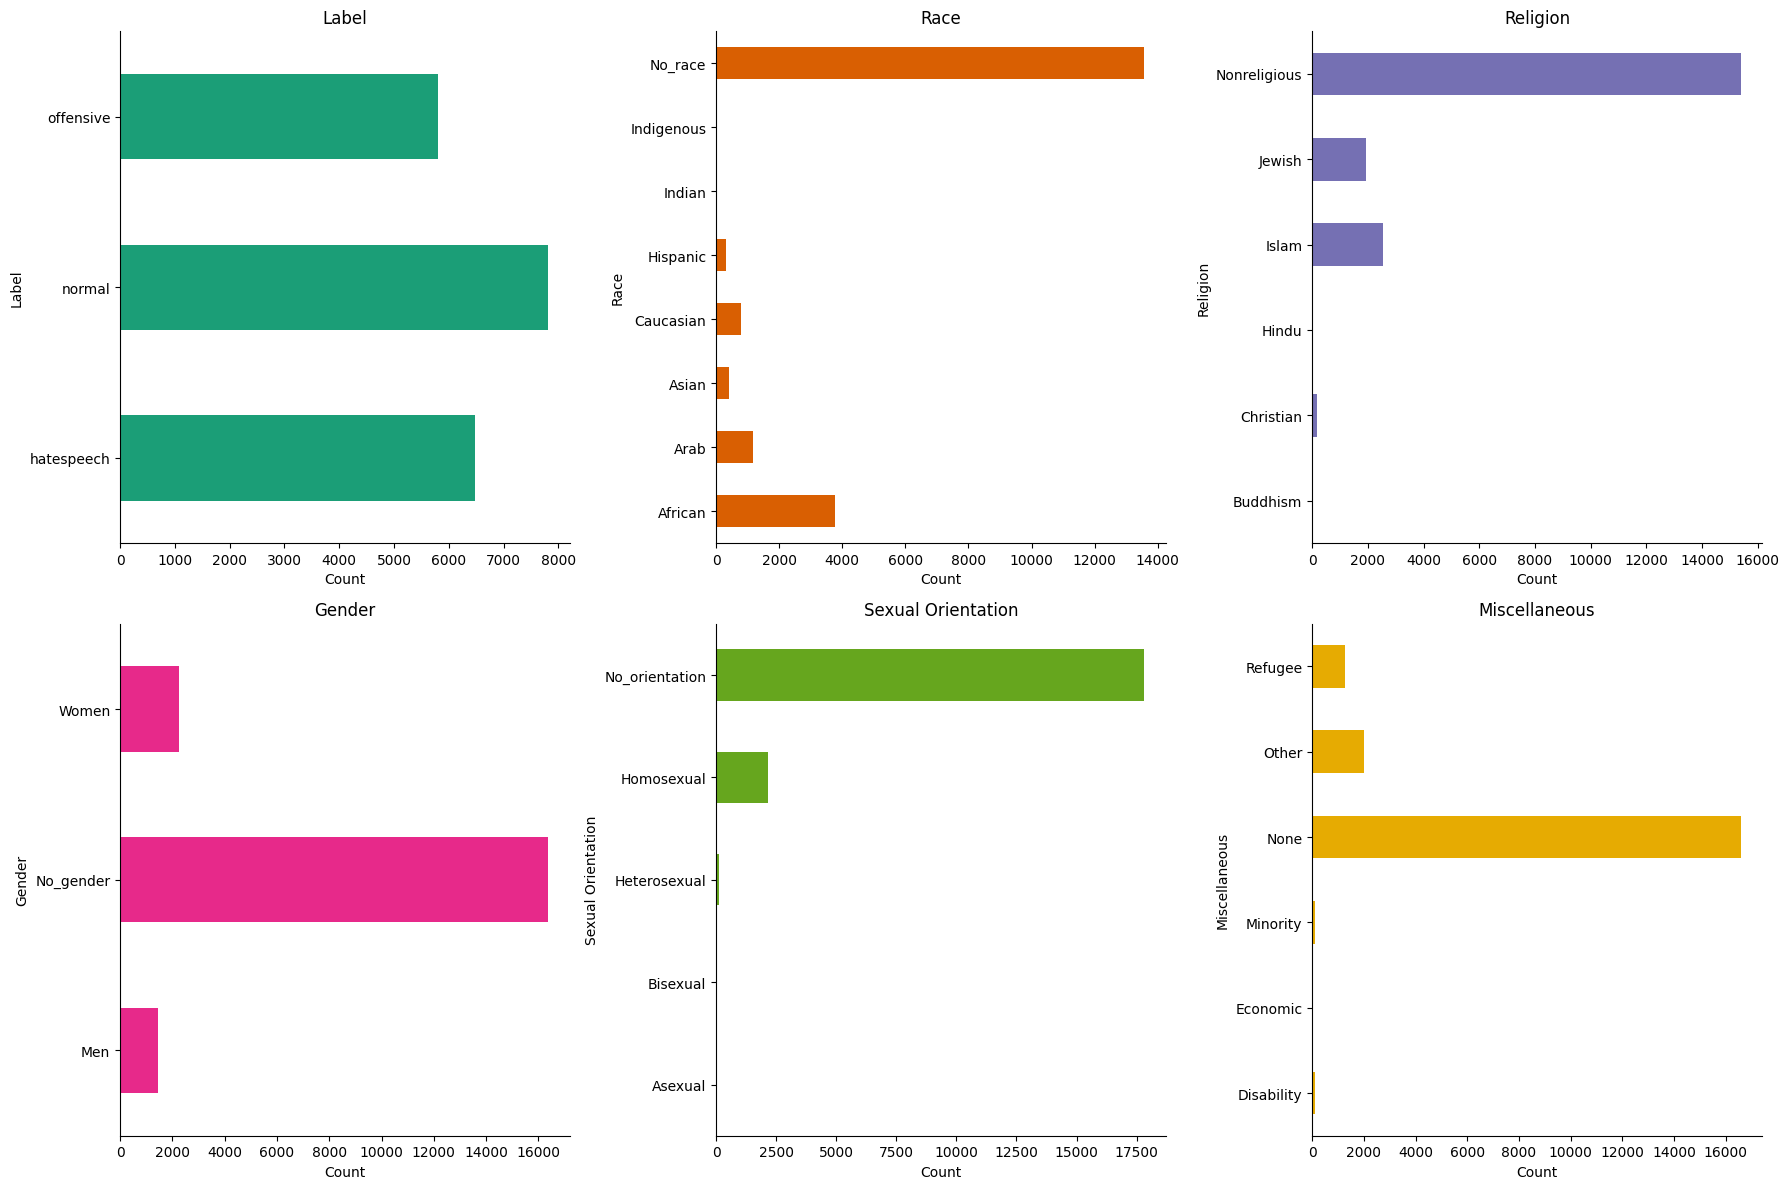

In [8]:
# Set up the color palette
color_palette = sns.palettes.mpl_palette('Dark2', n_colors=7)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Label
final_hateXplain_df.groupby('label').size().plot(kind='barh', ax=axes[0], color=color_palette[0])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_title('Label')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Label')

# Race
final_hateXplain_df.groupby('Race').size().plot(kind='barh', ax=axes[1], color=color_palette[1])
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].set_title('Race')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Race')

# Religion
final_hateXplain_df.groupby('Religion').size().plot(kind='barh', ax=axes[2], color=color_palette[2])
axes[2].spines[['top', 'right']].set_visible(False)
axes[2].set_title('Religion')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Religion')

# Gender
final_hateXplain_df.groupby('Gender').size().plot(kind='barh', ax=axes[3], color=color_palette[3])
axes[3].spines[['top', 'right']].set_visible(False)
axes[3].set_title('Gender')
axes[3].set_xlabel('Count')
axes[3].set_ylabel('Gender')

# Sexual Orientation
final_hateXplain_df.groupby('Sexual Orientation').size().plot(kind='barh', ax=axes[4], color=color_palette[4])
axes[4].spines[['top', 'right']].set_visible(False)
axes[4].set_title('Sexual Orientation')
axes[4].set_xlabel('Count')
axes[4].set_ylabel('Sexual Orientation')

# Miscellaneous
final_hateXplain_df.groupby('Miscellaneous').size().plot(kind='barh', ax=axes[5], color=color_palette[5])
axes[5].spines[['top', 'right']].set_visible(False)
axes[5].set_title('Miscellaneous')
axes[5].set_xlabel('Count')
axes[5].set_ylabel('Miscellaneous')

# Remove any unused subplots
for i in range(6, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Dataset 2: Toxic Comments Classification Challenge Dataset

In [9]:
# Dataset general information
len(toxic_comment_df)
toxic_comment_df.describe()
toxic_comment_df.info()
toxic_comment_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment        159571 non-null  object
 2   toxic          159571 non-null  object
 3   severe_toxic   159571 non-null  object
 4   obscene        159571 non-null  object
 5   threat         159571 non-null  object
 6   insult         159571 non-null  object
 7   identity_hate  159571 non-null  object
dtypes: object(8)
memory usage: 9.7+ MB


,0
id,0
comment,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


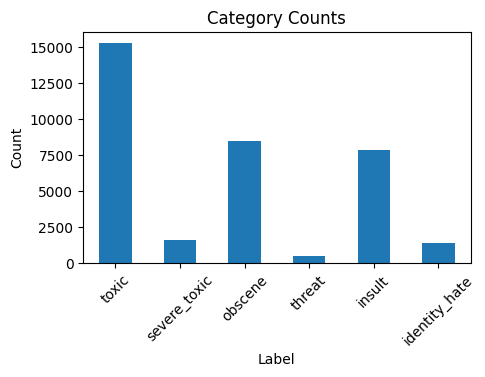

In [10]:
# Count number of comments per category
category_counts = toxic_comment_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(pd.to_numeric, errors='coerce').sum()

# Plotting
plt.figure(figsize=(5, 3))
category_counts.plot(kind='bar')
plt.title('Category Counts')
plt.ylabel('Count')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.show()

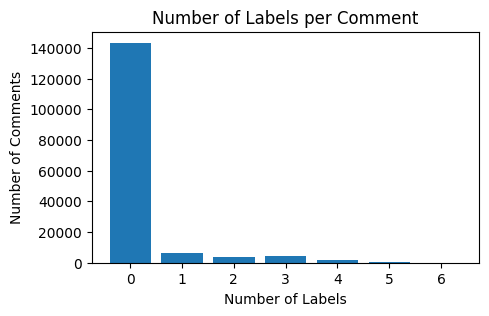

In [11]:
# Count number of labels per comment
label_count = toxic_comment_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(pd.to_numeric, errors='coerce').sum(axis=1)

# Plotting
plt.figure(figsize=(5, 3))
plt.hist(label_count, bins=range(0, label_count.max() + 2), align='left', rwidth=0.8)
plt.title('Number of Labels per Comment')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Comments')
plt.show()

# **Data Preprocessing**

In [12]:
columns_to_convert = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_comment_df[columns_to_convert] = toxic_comment_df[columns_to_convert].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Labels renaming
def classify_comment(row):
    if row['threat'] == 1 or row['identity_hate'] == 1:
        return 'hatespeech'
    elif row[['toxic', 'severe_toxic', 'obscene', 'insult']].sum() > 0:
        return 'offensive'
    else:
        return 'normal'

toxic_comment_df['label'] = toxic_comment_df.apply(classify_comment, axis=1)
display(toxic_comment_df.head())

,id,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,normal
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,normal
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,normal
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,normal
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,normal


In [14]:
# Combine the datasets
final_hateXplain_specific_df = final_hateXplain_df[['comment', 'label']]
toxic_comment_specific_df = toxic_comment_df[['comment', 'label']]

combined_df = pd.concat([final_hateXplain_specific_df, toxic_comment_specific_df], ignore_index=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

display(combined_df.head())

,comment,label
0,Mentone Grammar School Redux\nDefinitely a bit...,normal
1,"""==Your edits to Sammy Sosa==\nThank you for e...",normal
2,"""I don't think the majority of my posts are """"...",normal
3,Thanks alot... \n\nThe picture of those browni...,normal
4,Art Walk\nhere you go You can scroll through ...,normal


In [15]:
# General dataset information after merging
len(combined_df)
combined_df.describe()
combined_df.info()
combined_df.isnull().sum()
combined_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179680 entries, 0 to 179679
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  179680 non-null  object
 1   label    179680 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


,count
label,
normal,151164
offensive,20247
hatespeech,8269


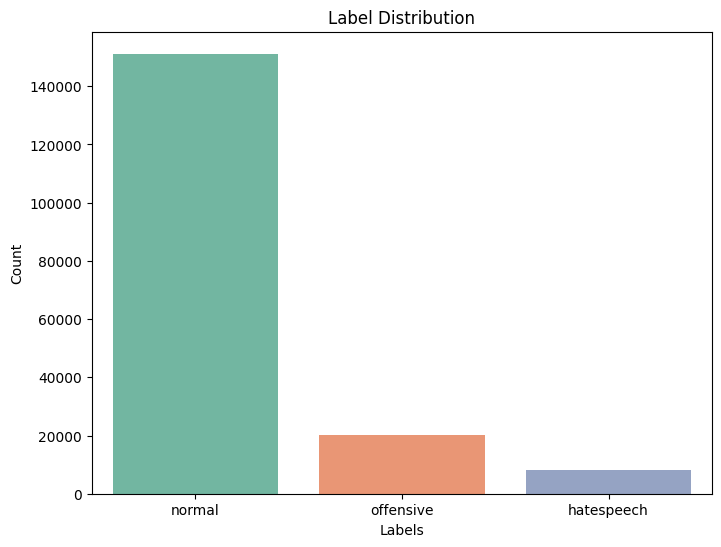

In [16]:
# Plot label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=combined_df, palette='Set2')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [17]:
# Count number of duplicate comments
duplicate_comments = combined_df[combined_df.duplicated(subset='comment', keep=False)]
print(f"Number of duplicate comments: {duplicate_comments.shape[0]}")

Number of duplicate comments: 2


In [18]:
# Calculate average comment length
combined_df['comment_length'] = combined_df['comment'].apply(len)
average_length = np.mean(combined_df['comment_length'])
print(f"Average comment length: {average_length} characters")

# Tokenize comments and remove stopwords for common vocabulary analysis
stop_words = set(stopwords.words('english'))
all_comments = ' '.join(combined_df['comment']).lower()
words = all_comments.split()

# Filter out stopwords and calculate word frequencies
filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
word_counts = Counter(filtered_words)

# Get the most common words
common_words = word_counts.most_common(10)
print("Most Common Words:")
for word, count in common_words:
    print(f"{word}: {count}")

Average comment length: 364.22908504007125 characters
Most Common Words:
article: 39047
would: 30046
page: 28751
like: 28441
please: 27707
one: 25707
talk: 23021
wikipedia: 22439
think: 19644
see: 19329


In [19]:
# Detect outliers based on comment length
q1 = combined_df['comment_length'].quantile(0.25)
q3 = combined_df['comment_length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = combined_df[(combined_df['comment_length'] < lower_bound) | (combined_df['comment_length'] > upper_bound)]
print(f"Number of outlier comments: {outliers.shape[0]}")

Number of outlier comments: 17285


In [20]:
# Common stem word. Got from chatgpt but cannot generate a link since it contains harmful language
replacements = {
    r"\w*can't\w*": "cannot",
    r"\w*don't\w*": "do not",
    r"\w*won't\w*": "will not",
    r"\w*hasn't\w*": "has not",
    r"\w*haven't\w*": "have not",
    r"\w*I'm\w*": "I am",
    r"\w*it's\w*": "it is",
    r"\w*you're\w*": "you are",
    r"\w*they're\w*": "they are",
    r"\w*we're\w*": "we are",
    r"\w*isn't\w*": "is not",
    r"\w*aren't\w*": "are not",
    r"\w*wasn't\w*": "was not",
    r"\w*weren't\w*": "were not",
    r"\w*I've\w*": "I have",
    r"\w*you've\w*": "you have",
    r"\w*they've\w*": "they have",
    r"\w*we've\w*": "we have",
    r"\w*I'll\w*": "I will",
    r"\w*you'll\w*": "you will",
    r"\w*they'll\w*": "they will",
    r"\w*we'll\w*": "we will",
    r"\w*lol\w*": "laughing out loud",
    r"\w*lmao\w*": "laughing my ass off",
    r"\w*brb\w*": "be right back",
    r"\w*tbh\w*": "to be honest",
    r"\w*smh\w*": "shaking my head",
    r"\w*wtf\w*": "what the fuck",
    r"\w*wtb\w*": "want to buy",
    r"\w*gg\w*": "good game",
    r"\w*gr8\w*": "great",
    r"\w*np\w*": "no problem",
    r"\w*fyi\w*": "for your information",
    r"\w*tmi\w*": "too much information",
    r"\w*ttyl\w*": "talk to you later",
    r"\w*rofl\w*": "rolling on the floor laughing",
    r"\w*bruh\w*": "brother or friend (often used in disbelief or annoyance)",
    r"\w*bae\w*": "before anyone else (usually in a romantic context)",
    r"\w*thx\w*": "thanks",
    r"\w*plz\w*": "please",
    r"\w*srsly\w*": "seriously",
    r"\w*ftw\w*": "for the win",
    r"\w*lmfao\w*": "laughing my fucking ass off",
    r"\w*smh\w*": "shaking my head",
    r"\w*omg\w*": "oh my god",
    r"\w*bruh\w*": "brother (used to express frustration or surprise)",
    r"\w*wtf\w*": "what the f*ck",
    r"\w*fml\w*": "fuck my life",
    r"\w*gtfo\w*": "get the fuck out",
    r"\w*slay\w*": "to perform excellently or look amazing",
    r"\w*hmu\w*": "hit me up",
    r"\w*ymmv\w*": "your mileage may vary",
    r"\w*goat\w*": "greatest of all time",
    r"\w*cbf\w*": "can't be fucked",
    r"\w*fcuk\w*": "fuck (variant)",
    r"\w*smd\w*": "suck my dick",
    r"\w*stfu\w*": "shut the fuck up",
    r"\w*nsfw\w*": "not safe for work",
    r"\w*np\w*": "no problem",
    r"\w*nvm\w*": "never mind",
    r"\w*irl\w*": "in real life",
    r"\w*fr\w*": "for real",
    r"\w*icho\w*": "I chose one of my own",
    r"\w*bs\w*": "bullshit",
    r"\w*dgaf\w*": "don't give a fuck",
    r"\w*fwiw\w*": "for what it's worth",
    r"\w*dm\w*": "direct message",
    r"\w*btw\w*": "by the way",
    r"\w*imo\w*": "in my opinion",
    r"\w*ik\w*": "I know",
    r"\w*jk\w*": "just kidding",
    r"\w*np\w*": "no problem",
    r"\w*ggwp\w*": "good game, well played",
    r"\w*smh\w*": "shaking my head",
    r"\w*fwiw\w*": "for what it's worth",
    r"\w*flamer\w*": "a person who insults others online",
    r"\w*ssdd\w*": "same shit, different day",
    r"\w*noob\w*": "newbie, inexperienced player",
    r"\w*lurker\w*": "someone who reads but does not engage in an online discussion",
    r"\w*l8r\w*": "later",
    r"\w*shook\w*": "shocked or surprised",
    r"\w*holla\w*": "hello, used especially in casual contexts",
    r"\w*bff\w*": "best friends forever",
    r"\w*mfw\w*": "my face when",
    r"\w*slaps\w*": "something that is really good or impressive (e.g., 'That song slaps!')",
    r"\w*g2g\w*": "got to go",
    r"\w*bruh\w*": "brother, often used when expressing disbelief or frustration",
    r"\w*af\w*": "as fuck (used for emphasis, e.g., 'I'm tired af')",
    r"\w*yeet\w*": "to throw something with force or excitement",
    r"\w*cap\w*": "lie (e.g., 'No cap' means 'no lie')",
    r"\w*stan\w*": "to be a huge fan or support someone intensely",
    r"\w*cx\w*": "cancel (used in texting to indicate that something has been canceled)",
    r"\w*kys\w*": "kill yourself (offensive and harmful, not encouraged)",
    r"\w*pov\w*": "point of view",
    r"\w*tryna\w*": "trying to",
    r"\w*clout\w*": "influence or power (especially in social media)",
    r"\w*wyd\w*": "what are you doing?",
    r"\w*2moro\w*": "tomorrow",
    r"\w*smh\w*": "shaking my head (used when something is ridiculous or frustrating)",
    r"\w*hbd\w*": "happy birthday",
    r"\w*ftb\w*": "from the bottom (e.g., 'I'm doing it from the bottom!')",
    r"\w*vs\w*": "versus (used in comparisons)",
    r"\w*copypasta\w*": "a block of text that is copied and pasted across the internet",
    r"\w*mood\w*": "a term used to describe one's emotional state, often used in memes",
    r"\w*flex\w*": "to show off",
    r"\w*ye\w*": "goodbye",
    r"\w*ttfn\w*": "ta-ta for now",
    r"\w*boi\w*": "boy (often used sarcastically or in jest)",
    r"\w*chill\w*": "to relax or take it easy",
    r"\w*noir\w*": "a genre of film or storytelling, often dark and brooding",
    r"\w*momol\w*": "making out in an awkward or silly way",
    r"\w*gd\w*": "good",
    r"\w*frosh\w*": "freshman",
    r"\w*ttys\w*": "talk to you soon",
    r"\w*bbs\w*": "be back soon",
    r"\w*l8\w*": "late",
    r"\w*oof\w*": "to smell unpleasantly or to describe something disappointing",
    r"\w*wtfbbq\w*": "what the f*ck, barbecue (sarcastic or humorous exaggeration)",
    r"\w*noted\w*": "message received, understood",
    r"\w*sksksk\w*": "expression of excitement or giddiness (often associated with certain subcultures like VSCO girls)",
    r"\w*rn\w*": "right now",
    r"\w*sis\w*": "sister, used casually or affectionately",
    r"\w*slay\w*": "to perform excellently, often in the context of appearance or confidence",
    r"\w*rip\w*": "rest in peace, used jokingly in response to something unfortunate or sad",
    r"\w*fbo\w*": "Facebook Official",
    r"\w*forreal\w*": "for real",
    r"\w*chad\w*": "a confident and attractive man, often used in internet slang",
    r"\w*brb\w*": "be right back",
    r"\w*tbh\w*": "to be honest",
    r"\w*sus\w*": "suspicious or shady",
    r"\w*glhf\w*": "good luck, have fun (often used in gaming)",
    r"\w*smh\w*": "shaking my head (used to express disbelief)",
    r"\w*big mood\w*": "I can totally relate to that feeling",
    r"\w*lit\w*": "exciting, great, or cool",
    r"\w*flex\w*": "to show off",
    r"\w*slaps\w*": "something that is really good (e.g., 'That song slaps!')",
    r"\w*dms\w*": "direct messages",
    r"\w*pog\w*": "play of the game, often used to describe something impressive",
    r"\w*hype\w*": "excitement or anticipation",
    r"\w*blm\w*": "Black Lives Matter",
    r"\w*ftw\w*": "for the win",
    r"\w*thx\w*": "thanks",
    r"\w*xo\w*": "hugs and kisses",
    r"\w*just vibing\w*": "enjoying the moment, not doing anything specific",
    r"\w*no cap\w*": "no lie, being honest",
    r"\w*fit\w*": "outfit (often used to describe one's clothing style)",
    r"\w*bae\w*": "before anyone else (in a romantic context)",
    r"\w*slay\w*": "to perform excellently or look amazing",
    r"\w*bruh\w*": "bro, often used in disbelief or surprise",
    r"\w*poggers\w*": "used to describe something impressive or cool (originates from gaming)",
    r"\w*stan\w*": "to be a huge fan or admirer of someone or something",
    r"\w*headass\w*": "used to describe something or someone as ridiculous or absurd",
    r"\w*catch these hands\w*": "to be physically challenged to a fight",
    r"\w*noob\w*": "a person who is new or inexperienced in something, especially in gaming",
    r"\w*bro\w*": "used to refer to a friend or a male acquaintance",
    r"\w*chill\w*": "to relax, to be laid back",
    r"\w*clout chaser\w*": "someone who seeks attention or fame from others",
    r"\w*finna\w*": "fixing to, going to (e.g., 'I'm finna go home')",
    r"\w*fam\w*": "family or close friends",
    r"\w*gang\w*": "a group of friends or people you hang out with",
    r"\w*md\w*": "message me",
    r"\w*pov\w*": "point of view",
    r"\w*mfw\w*": "my face when (used to describe a reaction to a situation)",
    r"\w*yo\w*": "hello, used informally",
    r"\w*lmaoo\w*": "laughing my a** off, used for emphasis",
    r"\w*wtb\w*": "want to buy",
    r"\w*irs\w*": "I am really sorry",
    r"\w*f2f\w*": "face-to-face",
    r"\w*lit\w*": "exciting, awesome",
    r"\w*mood\w*": "emotional state, especially in reference to relatable memes",
    r"\w*dm me\w*": "direct message me",
    r"\w*rip\w*": "rest in peace (used jokingly when something goes wrong)",
    r"\w*imho\w*": "in my humble opinion",
    r"\w*sus\w*": "suspicious or shady",
    r"\w*vc\w*": "voice chat",
    r"\w*fu\w*": "fuck you",
    r"\w*smh\w*": "shaking my head",
    r"\w*glhf\w*": "good luck, have fun",
    r"\w*lmfao\w*": "laughing my f*cking ass off",
    r"\w*gtg\w*": "got to go",
    r"\w*fr\w*": "for real",
    r"\w*frfr\w*": "for real for real",
    r"\w*slay\w*": "to perform excellently or look amazing",
    r"\w*nsfw\w*": "not safe for work (often used to refer to explicit content)",
    r"\w*smh\w*": "shaking my head",
    r"\w*rn\w*": "right now",
    r"\w*bc\w*": "bye bye, or big brother",
    r"\w*nope\w*": "no",
    r"\w*bae\w*": "before anyone else (usually referring to a significant other)",
    r"\w*fit\w*": "outfit",
    r"\w*bc\w*": "because",
    r"\w*dubs\w*": "wins",
    r"\w*sksksk\w*": "an expression of excitement or giddiness, often in online subcultures",
    r"\w*yeet\w*": "to throw something with force or excitement",
    r"\w*chad\w*": "a confident, typically attractive man",
    r"\w*boi\w*": "boy, used in a playful or sarcastic manner",
    r"\w*fr\w*": "for real",
    r"\w*peep\w*": "to look at or check out",
    r"\w*bet\w*": "to agree or confirm something (e.g., 'Bet, let's do it!')",
    r"\w*wya\w*": "where you at?",
    r"\w*irl\w*": "in real life",
    r"\w*fluff\w*": "empty talk or filler content",
    r"\w*lowkey\w*": "secretly or subtly",
    r"\w*highkey\w*": "openly or without shame",
    r"\w*sus\w*": "suspicious",
    r"\w*thx\w*": "thanks",
    r"\w*xd\w*": "expression of laughter or a smile",
    r"\w*wnb\w*": "would not be",
    r"\w*wyd\w*": "what you doing?",
    r"\w*yt\w*": "you too",
    r"\w*smd\w*": "suck my dick (offensive)",
    r"\w*ayt\w*": "at your service",
    r"\w*smfh\w*": "shaking my fucking head",
    r"\w*wtbs\w*": "what the big surprise",
    r"\w*fam\w*": "family or close friends",
    r"\w*ttys\w*": "talk to you soon",
    r"\w*yeet\w*": "to throw something with force, sometimes used as an exclamation",
    r"\w*slaps\w*": "something that is amazing, especially in reference to music",
    r"\w*chill\w*": "relax or take it easy",
    r"\w*boomer\w*": "an older person, often used in a derogatory way to refer to generational differences",
    r"\w*bro\w*": "brother, used casually for a male friend or acquaintance",
    r"\w*noob\w*": "newbie, someone who is inexperienced or new to something",
    r"\w*lmfao\w*": "laughing my fucking ass off",
    r"\w*thx\w*": "thanks"
}

In [21]:
stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Remove stopwords from the list of tokens.
def remove_stopwords(tokens):
    no_stopword_tokens = [word for word in tokens if word not in stopwords]
    return no_stopword_tokens

# Apply text replacements as per the predefined dictionary.
def replace_text(input_text):
    for pattern, replacement in replacements.items():
        input_text = re.sub(pattern, replacement, input_text, flags=re.IGNORECASE)
    return input_text

# Tokenize the input text.
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

# Map NLTK POS tag to WordNet POS tag.
def __get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatize tokens with respect to their POS tags.
def lemmatize_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, __get_wordnet_pos(tag))
        for token, tag in pos_tags
    ]
    return lemmatized_tokens

# Preprocess the input text by converting to lowercase, removing stopwords, and lemmatizing.
def preprocess_text(text):
    text = text.lower()                                        # Convert to lowercase
    text = replace_text(text)                                  # Apply text replacements
    text = re.sub(r'http\S+', '', text)                        # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)                    # Remove special characters and numbers
    tokens = tokenize(text)                                    # Tokenize the text
    no_stopwords_tokens = remove_stopwords(tokens)             # Remove stopwords
    lemmatized_tokens = lemmatize_tokens(no_stopwords_tokens)  # Lemmatize tokens
    return lemmatized_tokens

In [22]:
# Join tokanized comments to turn it into string
combined_df['comment'] = combined_df['comment'].apply(preprocess_text)
combined_df['comment'] = combined_df['comment'].str.join(' ')
display(combined_df.head())

,comment,label,comment_length
0,mentone grammar school redux definitely bit ri...,normal,385
1,hello use informally edit sammy sosa thank hel...,normal,298
2,think majority post vandalism mean polanski fa...,normal,279
3,thanks alot picture brother use casually male ...,normal,63
4,art walk hello use informally go hello use inf...,normal,192


In [23]:
# Save combined_dataset to save time in the future.
combined_df.to_csv('combined_dataset.csv', index=False)

# **Model Training**

In [24]:
# Run if we combined_df is not obtained above.
filename = "combined_dataset.csv"

combined_df_fields = []
combined_df_rows = []

with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    combined_df_fields = next(csvreader)

    for combined_df_row in csvreader:
        combined_df_rows.append(combined_df_row)

    print("Total no. of rows: %d" % (csvreader.line_num))

combined_df = pd.DataFrame(combined_df_rows)
combined_df.columns = combined_df_fields

display(combined_df.head())

Total no. of rows: 179681


,comment,label,comment_length
0,mentone grammar school redux definitely bit ri...,normal,385
1,hello use informally edit sammy sosa thank hel...,normal,298
2,think majority post vandalism mean polanski fa...,normal,279
3,thanks alot picture brother use casually male ...,normal,63
4,art walk hello use informally go hello use inf...,normal,192


In [25]:
# Preprocess the dataset
X = combined_df['comment']
y = combined_df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to Word2Vec embeddings
def get_word2vec_embeddings(text):
    tokens = text.split()
    embeddings = [word2vec_model[token] for token in tokens if token in word2vec_model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(word2vec_model.vector_size)

X_train_w2v = np.array([get_word2vec_embeddings(text) for text in tqdm(X_train)])
X_test_w2v = np.array([get_word2vec_embeddings(text) for text in tqdm(X_test)])

# Reduce dimensionality with PCA
pca = PCA(n_components=50, random_state=42)
X_train_reduced = pca.fit_transform(X_train_w2v)
X_test_reduced = pca.transform(X_test_w2v)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced, y_train)

100%|██████████| 35936/35936 [00:07<00:00, 5032.13it/s]


In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100, solver='saga', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
}

# Train and evaluate models
for model_name, model in models.items():
    print(f"\nTraining and Evaluating {model_name}...")
    if model_name == "Naive Bayes":
        # Handle Naive Bayes separately because it requires non-negative inputs
        model.fit(np.maximum(X_train_resampled, 0), y_train_resampled)
        predictions = model.predict(np.maximum(X_test_reduced, 0))
    else:
        model.fit(X_train_resampled, y_train_resampled)
        predictions = model.predict(X_test_reduced)

    # Display classification report
    print(f"Classification Report for {model_name}:")
    report = classification_report(y_test, predictions, target_names=y_train.unique())
    print(report)


Training and Evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      normal       0.26      0.65      0.38      1678
   offensive       0.97      0.83      0.89     30193
  hatespeech       0.40      0.60      0.48      4065

    accuracy                           0.79     35936
   macro avg       0.54      0.69      0.58     35936
weighted avg       0.87      0.79      0.82     35936


Training and Evaluating Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

      normal       0.27      0.52      0.35      1678
   offensive       0.95      0.85      0.90     30193
  hatespeech       0.40      0.54      0.46      4065

    accuracy                           0.80     35936
   macro avg       0.54      0.64      0.57     35936
weighted avg       0.85      0.80      0.82     35936


Training and Evaluating Random Forest...
Classification Report 